# 2. Train Model
Train a CNN classifier on the blood cell dataset.

In [1]:

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


In [2]:

import torch

# if torch.cuda.is_available():
#     device = torch.device('cuda')
#     print(f'Using CUDA on {torch.cuda.get_device_name(0)}')
# elif torch.backends.mps.is_available():
#     device = torch.device('mps')
#     print('Using MPS (Metal Performance Shaders) on Apple Silicon')
# else:
#     device = torch.device('cpu')
#     print('Using CPU')

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')



SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)
Epoch [1/4], Loss: 1.1548, Accuracy: 44.70%
Epoch [2/4], Loss: 0.7028, Accuracy: 71.68%
Epoch [3/4], Loss: 0.4261, Accuracy: 83.77%
Epoch [4/4], Loss: 0.2776, Accuracy: 89.68%


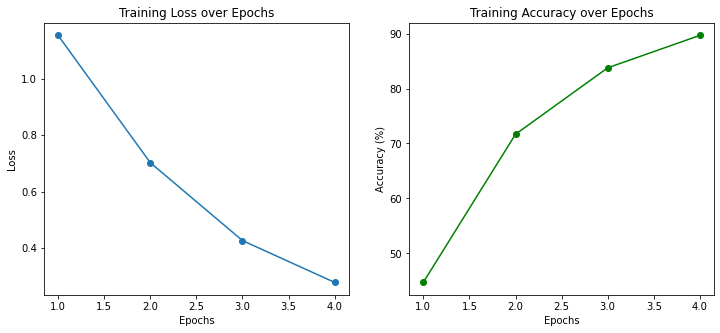

In [4]:

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = datasets.ImageFolder(root='../data/train', transform=transform)
test_dataset = datasets.ImageFolder(root='../data/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class SimpleCNN(torch.nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 32, 3, padding=1)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.fc1 = torch.nn.Linear(32 * 32 * 32, 128)
        self.fc2 = torch.nn.Linear(128, num_classes)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 32 * 32)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = SimpleCNN(num_classes=len(train_dataset.classes)).to(device)
print(model)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_accuracies = []
n_epochs = 4

for epoch in range(n_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

torch.save(model.state_dict(), '../models/best_model.pth')

# Plotting
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, n_epochs+1), train_losses, marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('../results/loss_plot.png')

plt.subplot(1,2,2)
plt.plot(range(1, n_epochs+1), train_accuracies, marker='o', color='green')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.savefig('../results/accuracy_plot.png')
plt.show()
